### Summarize the GA performance

In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
his_ave = np.load("ga_runs/SEGIDX_20251108_221605/history_avg.npy")
his_std = np.load("ga_runs/SEGIDX_20251108_221605/history_std.npy")
his_max = np.load("ga_runs/SEGIDX_20251108_221605/history_max.npy")
his_gen = np.load("ga_runs/SEGIDX_20251108_221605/history_gen.npy")

In [23]:
import json
raw_survivals = []
num_pulses = []
for i in range(40):
    with open(f"ga_runs/SEGIDX_20251108_221605/gen_{i:03d}/top1_meta.json") as file:
        meta = json.load(file)
        s = meta['raw_survivors']
        n = meta['num_pulses']
        raw_survivals.append(s)
        num_pulses.append(n)

raw_survivals = np.array(raw_survivals)
num_pulses = np.array(num_pulses)

In [48]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_ga_scores_publication(
    his_gen,
    his_ave,
    his_std,
    his_max,
    *,
    n_molecules=50_000,     # normalization factor if needed
    x_label="Generation",
    y_label="Score (normalized)",
    save_path=None,
    dpi=600
):
    """
    Publication-quality plot of GA average and best scores (single y-axis, no title).

    Parameters
    ----------
    his_gen : array-like
        Generation numbers.
    his_ave : array-like
        Average fitness values.
    his_std : array-like
        Standard deviation of fitness values.
    his_max : array-like
        Best fitness values.
    n_molecules : int, optional
        Normalization factor (default 50_000).
    save_path : str, optional
        If provided, saves the figure to this path (e.g., 'ga_scores.pdf').
    """

    # --- Publication styling context ---
    rc = {
        "font.family": "serif",
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "axes.linewidth": 0.8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.minor.visible": True,
        "ytick.minor.visible": True,
        "grid.color": "0.85",
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
    }

    with mpl.rc_context(rc):
        fig, ax = plt.subplots(figsize=(3.7*1.3, 2.4*1.3))

        # Normalize if needed
        ave_norm = np.asarray(his_ave, dtype=float) / n_molecules
        std_norm = np.asarray(his_std, dtype=float) / n_molecules
        max_norm = np.asarray(his_max, dtype=float) / n_molecules

        # Colors (colorblind-safe)
        c_avg = "#0072B2"   # blue
        c_best = "#D55E00"  # vermillion

        # Plot average score with error bars
        ax.errorbar(
            his_gen, ave_norm, yerr=std_norm,
            fmt="o-", lw=1.4, ms=4.2, capsize=3,
            color=c_avg, label="Score distribution"
        )

        # Plot best score
        ax.plot(
            his_gen, max_norm,
            "-s", lw=1.4, ms=4.2,
            color=c_best, label="Best score"
        )

        # Labels and grid
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.grid(True, which="both", alpha=0.6)

        # Adjust limits for aesthetics
        ymin = min(np.nanmin(ave_norm - std_norm), np.nanmin(max_norm))
        ymax = max(np.nanmax(ave_norm + std_norm), np.nanmax(max_norm))
        pad = 0.05 * (ymax - ymin)
        ax.set_ylim(ymin - pad, ymax + pad)

        # Legend (top center)
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=2,
            frameon=False,
            handlelength=2.0,
            columnspacing=1.5,
        )

        plt.tight_layout(rect=[0, 0, 1, 0.92])

        if save_path:
            plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        plt.show()


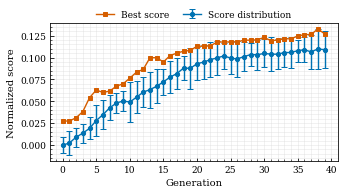

In [49]:
plot_ga_scores_publication(
    his_gen,
    his_ave,
    his_std,
    his_max,
    n_molecules=50_000,
    x_label="Generation",
    y_label="Normalized score",
    save_path="ga_scores_pub.pdf"  # vector output
)


In [38]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_dual_axis(
    his_gen,
    raw_survivals,
    num_pulses,
    raw_survivals_err=None,
    *,
    left_label="Ground-state rate",
    right_label="Number of pulses",
    x_label="Generation",
    title=None,
    save_path=None,
    dpi=600
):
    """
    Publication-quality dual-y plot:
      - Left y-axis: raw_survivals (with optional error bars)
      - Right y-axis: num_pulses
    """

    # --- Publication style (temporary context) ---
    rc = {
        "font.family": "serif",
        "font.size": 10,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.spines.top": True,        # ✅ include top frame
        "axes.spines.right": False,     # right handled by twinx
        "axes.linewidth": 0.8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.minor.visible": True,
        "ytick.minor.visible": True,
        "grid.color": "0.85",
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
    }

    with mpl.rc_context(rc):
        fig, ax1 = plt.subplots(figsize=(3.7*1.3, 2.5*1.3))  # single-column size

        # --- Colorblind-friendly palette ---
        c_left = "#0072B2"   # blue
        c_right = "#D55E00"  # vermillion

        # --- Left y-axis: raw_survivals ---
        if raw_survivals_err is not None:
            ax1.errorbar(
                his_gen, raw_survivals, yerr=raw_survivals_err,
                fmt="o-", lw=1.3, ms=4.5, capsize=3,
                color=c_left, label=left_label
            )
        else:
            ax1.plot(
                his_gen, raw_survivals, "o-", lw=1.5, ms=4.5,
                color=c_left, label=left_label
            )

        # Label and limits
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(left_label, color=c_left)
        ax1.tick_params(axis="y", colors=c_left)
        ax1.grid(True, which="both", alpha=0.5, zorder=0)

        # --- Right y-axis: num_pulses ---
        ax2 = ax1.twinx()
        ax2.spines["right"].set_visible(True)
        ax2.spines["right"].set_linewidth(0.8)
        ax2.plot(
            his_gen, num_pulses, "s--", lw=1.3, ms=4.2,
            color=c_right, label=right_label
        )
        ax2.set_ylabel(right_label, color=c_right)
        ax2.tick_params(axis="y", colors=c_right)

        # --- Tight y limits ---
        def _auto_ylim(y):
            ymin, ymax = np.nanmin(y), np.nanmax(y)
            if ymin == ymax:
                return ymin - 1, ymax + 1
            pad = 0.05 * (ymax - ymin)
            return ymin - pad, ymax + pad
        ax1.set_ylim(*_auto_ylim(raw_survivals))
        ax2.set_ylim(*_auto_ylim(num_pulses))

        # --- Title (shifted up slightly) ---
        if title:
            ax1.set_title(title, pad=12)

        # --- Layout adjustments ---
        plt.tight_layout(rect=[0, 0, 1, 0.93])  # leaves space for legend
        if save_path:
            plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        plt.show()


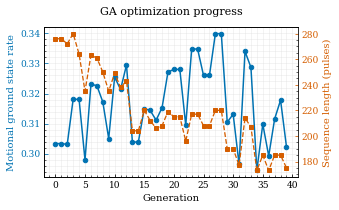

In [50]:

plot_dual_axis(
    his_gen,
    raw_survivals/50000,
    num_pulses,
    raw_survivals_err=None,  # or an array of SEMs
    left_label="Motional ground state rate",
    right_label="Sequence length (pulses)",
    title="GA optimization progress",
    save_path="ga_progress.pdf"   # vector format for publications
)
